In [52]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [53]:
file_dir = "/kaggle/input/plastik"
os.listdir(file_dir)

['hdpe_container',
 'pvc_unclear',
 'hdpe_botol',
 'ps',
 'pp_tutup_botol',
 'pp_botol',
 'pp_sedotan',
 'pet',
 'pp_container',
 'ldpe_bag',
 'ldpe_botol',
 'pvc_clear',
 'hdpe_tutup_botol']

In [54]:
img_height, img_width = (200, 200)
IMG_SIZE = (img_height, img_width)
IMG_SIZE_WITH_RGB = IMG_SIZE+(3,)
batch_size = 32

data_directory = "/kaggle/input/plastik"

In [55]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_directory,
    subset="training",
    validation_split=0.2,
    seed=2023,
    image_size=IMG_SIZE,
    batch_size=batch_size
)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_directory,
    subset="validation",
    validation_split=0.2,
    seed=2023,
    image_size=IMG_SIZE,
    batch_size=batch_size
)

Found 1909 files belonging to 13 classes.
Using 1528 files for training.
Found 1909 files belonging to 13 classes.
Using 381 files for validation.


In [56]:
train_data.class_names

class_names = train_data.class_names

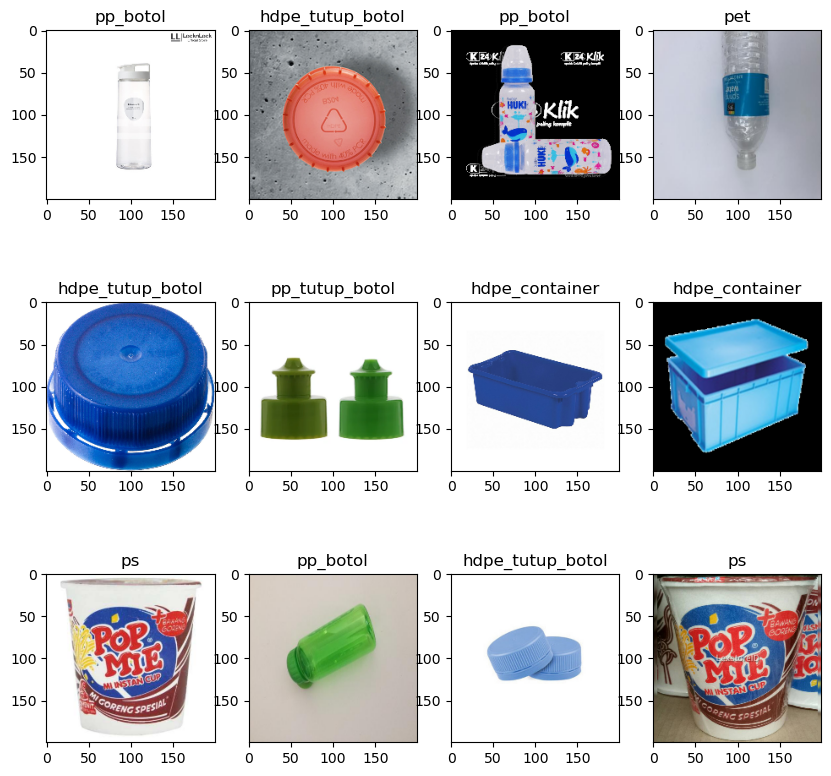

In [57]:
image_batch, label_batch = next(iter(train_data))

plt.figure(figsize=(10,10))
for i in range (12):
    
    ax = plt.subplot(3,4, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = class_names[label_batch[i]]
    plt.title(label)


In [58]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE_WITH_RGB,
    include_top=False,
    weights="imagenet"
)
base_model.trainable = True

In [59]:
image_batch, label_batch = next(iter(train_data))
feature_batch = base_model(image_batch)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_avg = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(len(class_names))

In [60]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') >= 0.8):
      self.model.stop_training = True

callbacks = myCallback()

In [61]:
dropout_param = 0.4
learning_rate = 1e-4

model = tf.keras.Sequential([
    tf.keras.Input(shape=IMG_SIZE_WITH_RGB),
    data_augmentation,
    tf.keras.layers.Lambda(preprocess_input),
    base_model,   
    global_average_layer,
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(dropout_param),
    tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(256, activation="relu"),
#     tf.keras.layers.Dropout(dropout_param),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(512, activation="relu"),
#     tf.keras.layers.Dropout(dropout_param),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(1024, activation="relu"),
#     tf.keras.layers.Dropout(dropout_param),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(2048, activation="relu"),
#     tf.keras.layers.Dropout(dropout_param),
#     tf.keras.layers.BatchNormalization(),
    prediction_layer
])



model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [62]:
initial_epochs = 300

loss0, accuracy0 = model.evaluate(validation_data)
print(loss0, accuracy0)

12/12 [==============================] - 8s 142ms/step - loss: 2.8237 - accuracy: 0.0682
2.8236799240112305 0.06824146956205368


In [63]:
history = model.fit(train_data,
                    epochs=initial_epochs,
                    validation_data=validation_data, callbacks=[callbacks])

Epoch 1/300
48/48 [==============================] - 63s 654ms/step - loss: 2.5715 - accuracy: 0.2120 - val_loss: 1.9700 - val_accuracy: 0.3386
Epoch 2/300
48/48 [==============================] - 35s 662ms/step - loss: 1.6853 - accuracy: 0.4705 - val_loss: 1.6073 - val_accuracy: 0.4882
Epoch 3/300
48/48 [==============================] - 39s 752ms/step - loss: 1.3287 - accuracy: 0.5628 - val_loss: 1.4373 - val_accuracy: 0.5276
Epoch 4/300
48/48 [==============================] - 35s 661ms/step - loss: 1.1000 - accuracy: 0.6479 - val_loss: 1.2855 - val_accuracy: 0.6010
Epoch 5/300
48/48 [==============================] - 35s 667ms/step - loss: 0.9521 - accuracy: 0.7048 - val_loss: 1.2008 - val_accuracy: 0.6089
Epoch 6/300
48/48 [==============================] - 35s 663ms/step - loss: 0.8276 - accuracy: 0.7343 - val_loss: 1.0558 - val_accuracy: 0.6535
Epoch 7/300
48/48 [==============================] - 35s 663ms/step - loss: 0.7439 - accuracy: 0.7709 - val_loss: 1.0072 - val_accuracy:

In [64]:
import pickle

model_file_path = "New3_MobileNetV2_1e-4_80Split_Adam_Dense_with02Dropout.pkl"
with open(model_file_path, "wb") as file:
    pickle.dump(model, file)

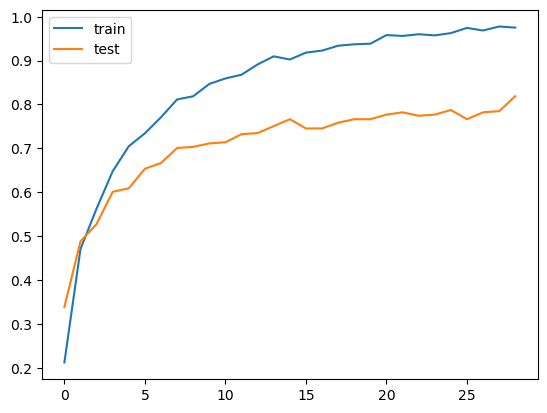

In [66]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'test'], loc='upper left')


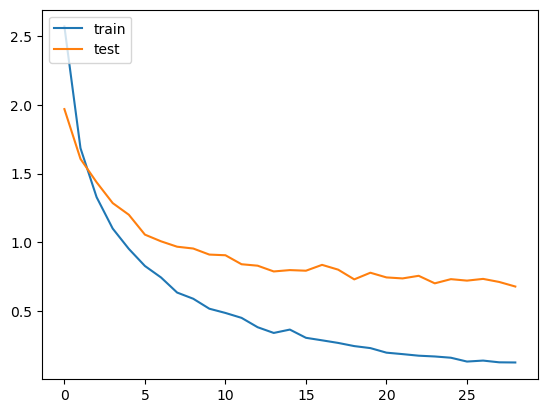

In [67]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')

1/1 [==============================] - 0s 32ms/step
[[ 0.86696637 -1.1972542  -0.45688206  0.1553846   0.34026507 -0.347042
  -0.07583284 -0.41187608  0.67174375  0.9217838  -0.45722133  0.4105499
   0.90425587]]
pp_tutup_botol


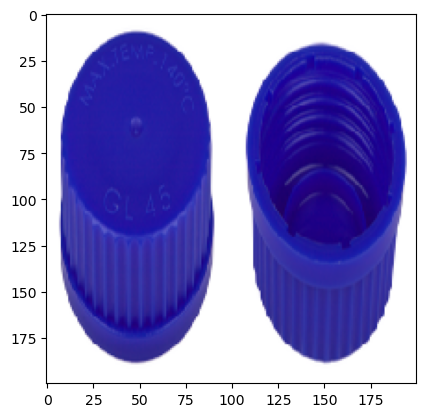

In [78]:
import os

image = tf.keras.preprocessing.image.load_img("/kaggle/input/plastik/pp_tutup_botol/1509749737_34_11zon.png", target_size=(200,200))
plt.imshow(image)
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
input_arr = input_arr.astype('float32') / 255
result = model.predict(input_arr)
print(result)
print(class_names[np.argmax(result)])